In [1]:
import argparse

import torch.optim as optim
import torch.utils.data.sampler as sampler

from auto_lambda import AutoLambda
from create_network import *
from create_dataset import *
from create_network import MTANDeepLabv3, MTLDeepLabv3
from utils import *
from misc import genWeights

import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter


class trainerDense:

    def __init__(self,
                mode='none',
                port='none',
                network='split',
                weight='equal',
                grad_method='none',
                gpu=0,
                with_noise=False,  # Cambiado 'store_true' a False
                autol_init=0.1,
                autol_lr=1e-4,
                task='all',
                dataset='nyuv2',
                seed = 0,
                total_epoch = 50):

        self.mode = mode
        self.port = port
        self.network = network
        self.weight = weight
        self.grad_method = grad_method
        self.gpu = gpu
        self.with_noise = with_noise  # Cambiado 'store_true' a False
        self.autol_init = autol_init
        self.autol_lr = autol_lr
        self.task = task
        self.dataset = dataset
        self.seed = int(seed)
        self.device = None
        self.train_tasks = None

        self.total_epoch = total_epoch


    def initialize(self):
        torch.manual_seed(0)
        np.random.seed(0)
        random.seed(0)

        # create logging folder to store training weights and losses
        if not os.path.exists('logging'):
            os.makedirs('logging')

        # Crear un directorio para los registros de TensorBoard
        self.log_dir = 'tensorboard_logs'  # Puedes cambiar este nombre según tus preferencias
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)


        # define model, optimiser and scheduler
        self.device = torch.device("cuda:{}".format(int(self.gpu)) if torch.cuda.is_available() else "cpu")
        if self.with_noise:
            self.train_tasks = create_task_flags('all', self.dataset, with_noise=True)
        else:
            self.train_tasks = create_task_flags('all', self.dataset, with_noise=False)

        self.pri_tasks = create_task_flags(self.task, self.dataset, with_noise=False)

        train_tasks_str = ''.join(task.title() + ' + ' for task in self.train_tasks.keys())[:-3]
        pri_tasks_str = ''.join(task.title() + ' + ' for task in self.pri_tasks.keys())[:-3]

        print('Dataset: {} | Training Task: {} | Primary Task: {} in Multi-task / Auxiliary Learning Mode with {}'
            .format(self.dataset.title(), train_tasks_str, pri_tasks_str, self.network.upper()))
        print('Applying Multi-task Methods: Weighting-based: {} + Gradient-based: {}'
            .format(self.weight.title(), self.grad_method.upper()))

        if self.network == 'split':
            self.model = MTLDeepLabv3(self.train_tasks).to(self.device)
        elif self.network == 'mtan':
            self.model = MTANDeepLabv3(self.train_tasks).to(self.device)


    def choose_task_weighting(self, weight):

        if weight == 'uncert':
            logsigma = torch.tensor([-0.7] * len(self.train_tasks), requires_grad=True, device=self.device)
            self.params = list(self.model.parameters()) + [logsigma]
            self.logsigma_ls = np.zeros([self.total_epoch, len(self.train_tasks)], dtype=np.float32)

        if weight in ['dwa', 'equal']:
            self.T = 2.0  # temperatura utilizada en dwa
            self.lambda_weight = np.ones([self.total_epoch, len(self.train_tasks)])
            self.params = self.model.parameters()

        if weight == 'autol':
            self.params = self.model.parameters()
            self.autol = AutoLambda(self.model, self.device, self.train_tasks, self.pri_tasks, self.autol_init)
            self.meta_weight_ls = np.zeros([self.total_epoch, len(self.train_tasks)], dtype=np.float32)
            self.meta_optimizer = optim.Adam([self.autol.meta_weights], lr=self.autol_lr)


        # para probar combinaciones de pesos
        if weight == 'combinations':
            #numero de pesos
            nw = 11
            #genera pesos
            self.my_weight = genWeights(nw, len(self.train_tasks), self.device)
            self.lambda_weight = np.ones([self.total_epoch, len(self.train_tasks)])
            print('primer lambda ', self.lambda_weight.shape)
            self.params = self.model.parameters()

        self.optimizer = optim.SGD(self.params, lr=0.1, weight_decay=1e-4, momentum=0.9)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.total_epoch)

        # una copia de train_loader con diferente orden de datos, utilizada para la actualización meta de Auto-Lambda
        if weight == 'autol':
            self.val_loader = torch.utils.data.DataLoader(
                dataset= self.train_set,
                batch_size = self.batch_size,
                shuffle=True,
                num_workers=4
            )



    def define_dataset(self, dataset):

        if dataset == 'nyuv2':
            dataset_path = 'dataset/nyuv2'
            train_set = NYUv2(root=dataset_path, train=True, augmentation=True)
            test_set = NYUv2(root=dataset_path, train=False)
            self.batch_size = 4
        elif dataset == 'cityscapes':
            dataset_path = 'dataset/cityscapes'
            train_set = CityScapes(root=dataset_path, train=True, augmentation=True)
            test_set = CityScapes(root=dataset_path, train=False)
            self.batch_size = 4

    #def define_data_loader(self):

        self.train_loader = torch.utils.data.DataLoader(
            dataset = train_set,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )

        self.test_loader = torch.utils.data.DataLoader(
            dataset = test_set,
            batch_size = self.batch_size,
            shuffle = False
        )

    def apply_gradient_methods(self, grad_method):
    # apply gradient methods
        if grad_method != 'none':
            self.rng = np.random.default_rng()
            self.grad_dims = []
            for mm in self.model.shared_modules():
                for param in mm.parameters():
                    self.grad_dims.append(param.data.numel())
            self.grads = torch.Tensor(sum(self.grad_dims), len(self.train_tasks)).to(self.device)


    def update_weights(self, index):
        if self.weight == 'dwa':
            self.update_weights_dwa(index)
        elif self.weight == 'uncert':
            self.update_weights_uncert(index)
        elif self.weight == 'autol':
            self.update_weights_autol(index)
        elif self.weight == 'combinations':
            self.update_weights_combinations(index)

    def update_weights_dwa(self, index):
        if index == 0 or index == 1:
            self.lambda_weight[index, :] = 1.0
        else:
            w = []
            for i, t in enumerate(self.train_tasks):
                w += [self.train_metric.metric[t][index - 1, 0] / self.train_metric.metric[t][index - 2, 0]]
            w = torch.softmax(torch.tensor(w) / self.T, dim=0)
            self.lambda_weight[index] = len(self.train_tasks) * w.numpy()

    def update_weights_uncert(self, index):
        # Lógica para actualizar pesos basados en incertidumbre
        pass

    def update_weights_autol(self, index):
        # Lógica para actualizar pesos con Auto-Lambda
        pass

    def update_weights_combinations(self, index):
        # Lógica para actualizar pesos en caso de combinaciones de pesos
        pass

    def registra_info_tboard(writer, epoca, hist):
        for (m,v) in hist.items():
            writer.add_scalar(m, v[epoca], epoca)



    def train_one_epoch(self, index):
        print('Epoch: ', index)

        self.model.train()
        train_dataset = iter(self.train_loader)

        if self.weight == 'autol':
            val_dataset = iter(self.val_loader)

        for k in range(self.train_batch):
            train_data, train_target = next(train_dataset)
            train_data = train_data.to(self.device)
            train_target = {task_id: train_target[task_id].to(self.device) for task_id in self.train_tasks.keys()}

            # Actualizar meta-pesos con Auto-Lambda
            if self.weight == 'autol':
                val_data, val_target = next(val_dataset)
                val_data = val_data.to(self.device)
                val_target = {task_id: val_target[task_id].to(self.device) for task_id in self.train_tasks.keys()}

                self.meta_optimizer.zero_grad()
                self.autol.unrolled_backward(train_data, train_target, val_data, val_target, self.scheduler.get_last_lr()[0], self.optimizer)
                self.meta_optimizer.step()

            # Actualizar parámetros de la red multi-tarea con pesos de tareas
            self.optimizer.zero_grad()
            train_pred = self.model(train_data)
            train_loss = [compute_loss(train_pred[i], train_target[task_id], task_id) for i, task_id in enumerate(self.train_tasks)]

            train_loss_tmp = [0] * len(self.train_tasks)

            if self.weight in ['equal', 'dwa', 'combinations']:
                train_loss_tmp = [w * train_loss[i] for i, w in enumerate(self.lambda_weight[index])]

            if self.weight == 'uncert':
                train_loss_tmp = [1 / (2 * torch.exp(w)) * train_loss[i] + w / 2 for i, w in enumerate(self.logsigma)]

            if self.weight == 'autol':
                train_loss_tmp = [w * train_loss[i] for i, w in enumerate(self.autol.meta_weights)]

            loss = sum(train_loss_tmp)

            if self.grad_method == 'none':
                loss.backward()
                self.optimizer.step()

            # Métodos basados en gradientes aplicados aquí
            elif self.grad_method == "graddrop":
                for i in range(len(self.train_tasks)):
                    train_loss_tmp[i].backward(retain_graph=True)
                    self.grad2vec(self.model, self.grads, self.grad_dims, i)
                    self.model.zero_grad_shared_modules()
                g = self.graddrop(self.grads)
                self.overwrite_grad(self.model, g, self.grad_dims, len(self.train_tasks))
                self.optimizer.step()

            elif self.grad_method == "pcgrad":
                for i in range(len(self.train_tasks)):
                    train_loss_tmp[i].backward(retain_graph=True)
                    self.grad2vec(self.model, self.grads, self.grad_dims, i)
                    self.model.zero_grad_shared_modules()
                g = self.pcgrad(self.grads, self.rng, len(self.train_tasks))
                self.overwrite_grad(self.model, g, self.grad_dims, len(self.train_tasks))
                self.optimizer.step()

            elif self.grad_method == "cagrad":
                for i in range(len(self.train_tasks)):
                    train_loss_tmp[i].backward(retain_graph=True)
                    self.grad2vec(self.model, self.grads, self.grad_dims, i)
                    self.model.zero_grad_shared_modules()
                g = self.cagrad(self.grads, len(self.train_tasks), 0.4, rescale=1)
                self.overwrite_grad(self.model, g, self.grad_dims, len(self.train_tasks))
                self.optimizer.step()

            self.train_metric.update_metric(train_pred, train_target, train_loss)

        #train_str = self.train_metric.compute_metric()
        #self.train_metric.reset()


    def evaluate_metrics(self, test_dataset):
        self.model.eval()
        with torch.no_grad():
            test_dataset = iter(test_dataset)
            for k in range(self.test_batch):
                test_data, test_target = next(test_dataset)
                test_data = test_data.to(self.device)
                test_target = {task_id: test_target[task_id].to(self.device) for task_id in self.train_tasks.keys()}

                test_pred = self.model(test_data)
                test_loss = [compute_loss(test_pred[i], test_target[task_id], task_id) for i, task_id in enumerate(self.train_tasks)]
                self.test_metric.update_metric(test_pred, test_target, test_loss)

            #return test_pred, test_target, test_loss

    def print_and_save_results(self, index, writer, peso_actual):
        train_str = self.train_metric.compute_metric()
        self.train_metric.reset()
        test_str = self.test_metric.compute_metric()
        self.test_metric.reset()

        # Agregar métricas a TensorBoard
        #writer.add_scalar(f'Train/{self.task}_Loss', self.train_metric.get_best_performance(self.task), index)
        #writer.add_scalar(f'Test/{self.task}_Loss', self.test_metric.get_best_performance(self.task), index)


        print('Época {:04d} | TRAIN:{} || TEST:{} | Best: {} {:.4f}'
            .format(index, train_str, test_str, self.task.title(), self.test_metric.get_best_performance(self.task)))

        if self.weight == 'autol':
            self.meta_weight_ls[index] = self.autol.meta_weights.detach().cpu()
            results_dict = {'train_loss': self.train_metric.metric, 'test_loss': self.test_metric.metric, 'weight': self.meta_weight_ls}
            print(get_weight_str(self.meta_weight_ls[index], self.train_tasks))

        if self.weight in ['dwa', 'equal', 'combinations']:
            results_dict = {'train_loss': self.train_metric.metric,
                            'test_loss': self.test_metric.metric,
                            'weight': self.lambda_weight}
            print(get_weight_str(self.lambda_weight[index], self.train_tasks))

            # Agregar métricas específicas al SummaryWriter de TensorBoard

          #  for metric_name, metric_values in results_dict.items():
                # Aquí, metric_name sería el nombre de la métrica (por ejemplo, 'train_loss' o 'test_loss')
                # metric_values sería un array con los valores de la métrica en cada época
           #
           #     for epoch, value in enumerate(metric_values):
                    # Agregar la métrica al SummaryWriter
           #         writer.add_scalar(f'Weighting/{metric_name}', value, epoch)



        if self.weight == 'uncert':
            self.logsigma_ls[index] = self.logsigma.detach().cpu()
            results_dict = {'train_loss': self.train_metric.metric, 'test_loss': self.test_metric.metric, 'weight': self.logsigma_ls}
            print(get_weight_str(1 / (2 * np.exp(self.logsigma_ls[index])), self.train_tasks))

        np.save('logging/mtl_dense_{}_{}_{}_{}_{}_{}_{}.npy'
                .format(self.network, self.dataset, self.task, self.weight, self.grad_method, self.seed, peso_actual), results_dict)


    def plot_performance(self, save = True):
        # Obtén la lista de claves de las métricas
        train_metric_keys = list(self.train_metric.metric.keys())

        # Calcula el número de métricas
        num_metrics = len(train_metric_keys)
        labels = ['Loss', 'task-specific metric']

        fig, axes = plt.subplots(2, num_metrics, figsize=(16, 8))  # Ajusta el tamaño según tus necesidades

        for j in range(2):

            # Recorre las métricas y crea los gráficos
            for i, key in enumerate(train_metric_keys):
                # Gráfico de métrica de entrenamiento
                axes[j,i].plot(self.train_metric.metric[key][:, j], label=f'Train {key}')
                axes[j, i].plot(self.test_metric.metric[key][:, j], label=f'Test {key}')
                axes[j, i].set_xlabel('Epoch')
                axes[j, i].set_ylabel(labels[j])
                axes[j, i].set_title(key)
                axes[j, i].legend()  # Agrega una leyenda para cada gráfico

            # Ajusta el espaciado entre los subgráficos
            plt.tight_layout()
        if save:
            plt.savefig('figures/' + get_weight_str(self.lambda_weight[0], self.train_tasks) + self.dataset + '.pdf' )
            plt.savefig('figures/' + get_weight_str(self.lambda_weight[0], self.train_tasks) + self.dataset + '.png' )
        # Muestra los subgráficos
        plt.show()
        #plt.close()



    def train(self):
        if self.weight == 'combinations':
            w = self.my_weight

        else:
            w = np.ones([1, 1])
            tensorboard_log_dir = self.log_dir


        #for j in range(w.shape[-1]):
        for j in range(5, w.shape[-1]):
            self.apply_gradient_methods(self.grad_method)
            self.train_batch = len(self.train_loader)
            self.test_batch = len(self.test_loader)
            self.train_metric = TaskMetric(self.train_tasks, self.pri_tasks, self.batch_size, self.total_epoch, self.dataset)
            self.test_metric = TaskMetric(self.train_tasks, self.pri_tasks, self.batch_size, self.total_epoch, self.dataset, include_mtl=True)

            tensorboard_log_dir = os.path.join(self.log_dir, get_weight_str(self.lambda_weight[0], self.train_tasks))
            writer = SummaryWriter(tensorboard_log_dir)

            print('\nProbando combinación de pesos: ',  w[:,j].tolist())
            if self.weight == 'combinations':
                self.lambda_weight = np.tile(w[:, j].numpy(), (self.total_epoch, 1))

            for index in range(self.total_epoch):
                self.update_weights(index)
                self.train_one_epoch(index)

                #train_str = self.train_metric.compute_metric()
                #self.train_metric.reset()


                self.evaluate_metrics(self.test_loader)

                #test_str = self.test_metric.compute_metric()
                #self.test_metric.reset()

                self.scheduler.step()

                peso_actual = w[:,j].tolist()
                self.print_and_save_results(index, writer, peso_actual)
                torch.cuda.empty_cache()
            # Cerrar el SummaryWriter de TensorBoard al final del entrenamiento
            writer.close()
            self.plot_performance()
            torch.cuda.empty_cache()






/home/carmen/anaconda3/envs/autolambda_20230816/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-10 01:10:38.553693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 01:10:39.065797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/carmen/anaconda3/envs/autolambda_20230816/lib/python3.7/site-packages/cv2/../../lib64:
2023-11-10 01:10:39.065839:

In [2]:
t = trainerDense(dataset = 'cityscapes', total_epoch = 200, weight = 'combinations')
t.initialize()
t.choose_task_weighting(weight = 'combinations')
t.define_dataset(dataset = 'cityscapes')

Dataset: Cityscapes | Training Task: Seg + Part_Seg + Disp | Primary Task: Seg + Part_Seg + Disp in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Combinations + Gradient-based: NONE
primer lambda  (200, 3)



Probando combinación de pesos:  [0.0, 0.0, 1.0]
Epoch:  0
Época 0000 | TRAIN: Seg 2.9933 0.0104 Part_seg 2.1953 0.0181 Disp 1.8031 1.8031 || TEST: Seg 3.0198 0.0106 Part_seg 2.2696 0.0148 Disp 1.7655 1.7655 | All -1.0183 | Best: All -1.0183
Task Weighting | Seg 0.0000 Part_Seg 0.0000 Disp 1.0000 
Epoch:  1
Época 0001 | TRAIN: Seg 2.9831 0.0118 Part_seg 2.1970 0.0187 Disp 1.4567 1.4567 || TEST: Seg 3.0010 0.0110 Part_seg 2.2602 0.0135 Disp 1.4976 1.4976 | All -0.9126 | Best: All -0.9126
Task Weighting | Seg 0.0000 Part_Seg 0.0000 Disp 1.0000 
Epoch:  2
Época 0002 | TRAIN: Seg 2.9602 0.0126 Part_seg 2.2055 0.0205 Disp 1.3721 1.3721 || TEST: Seg 2.9825 0.0085 Part_seg 2.2492 0.0137 Disp 1.5568 1.5568 | All -0.9374 | Best: All -0.9126
Task Weighting | Seg 0.0000 Part_Seg 0.0000 Disp 1.0000 
Epoch:  3
Época 0003 | TRAIN: Seg 2.9575 0.0132 Part_seg 2.2156 0.0206 Disp 1.2953 1.2953 || TEST: Seg 2.9423 0.0121 Part_seg 2.2410 0.0150 Disp 1.5562 1.5562 | All -0.9342 | Best: All -0.9126
Task Wei

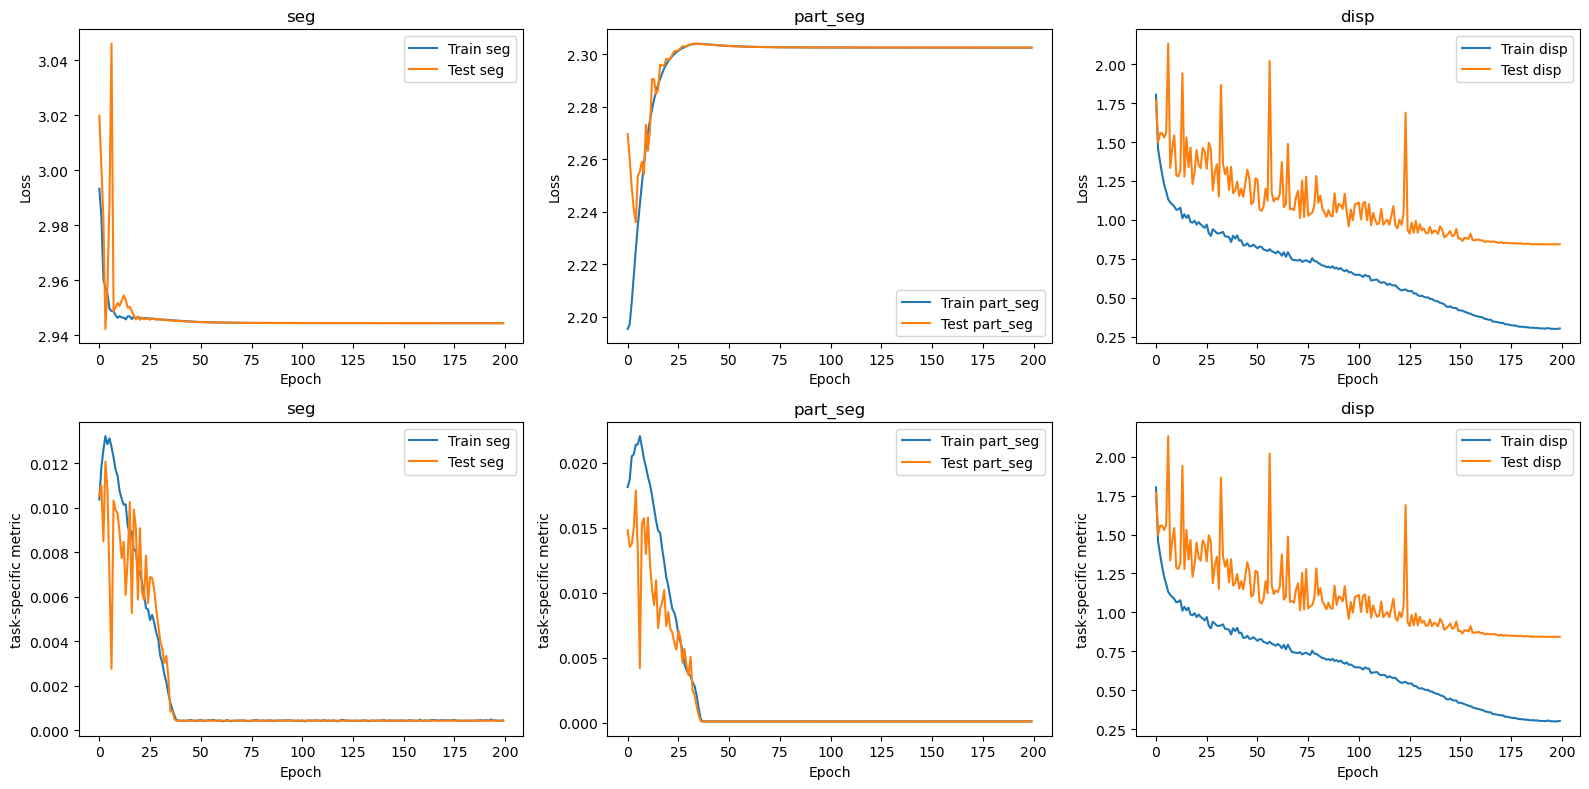


Probando combinación de pesos:  [0.0, 0.3389028824102541, 0.6610971175897459]
Epoch:  0
Época 0000 | TRAIN: Seg 2.9444 0.0004 Part_seg 2.3026 0.0001 Disp 0.3003 0.3003 || TEST: Seg 2.9444 0.0004 Part_seg 2.3026 0.0001 Disp 0.8414 0.8414 | All -0.6669 | Best: All -0.6669
Task Weighting | Seg 0.0000 Part_Seg 0.3389 Disp 0.6611 
Epoch:  1
Época 0001 | TRAIN: Seg 2.9444 0.0004 Part_seg 2.2966 0.0930 Disp 0.3016 0.3016 || TEST: Seg 2.9444 0.0004 Part_seg 2.2907 0.0925 Disp 0.8410 0.8410 | All -0.6084 | Best: All -0.6084
Task Weighting | Seg 0.0000 Part_Seg 0.3389 Disp 0.6611 
Epoch:  2
Época 0002 | TRAIN: Seg 2.9444 0.0005 Part_seg 2.2668 0.0933 Disp 0.3024 0.3024 || TEST: Seg 2.9444 0.0004 Part_seg 2.2436 0.0925 Disp 0.8422 0.8422 | All -0.6089 | Best: All -0.6084
Task Weighting | Seg 0.0000 Part_Seg 0.3389 Disp 0.6611 
Epoch:  3
Época 0003 | TRAIN: Seg 2.9444 0.0004 Part_seg 2.1907 0.0932 Disp 0.2985 0.2985 || TEST: Seg 2.9444 0.0004 Part_seg 2.1400 0.0925 Disp 0.8428 0.8428 | All -0.609

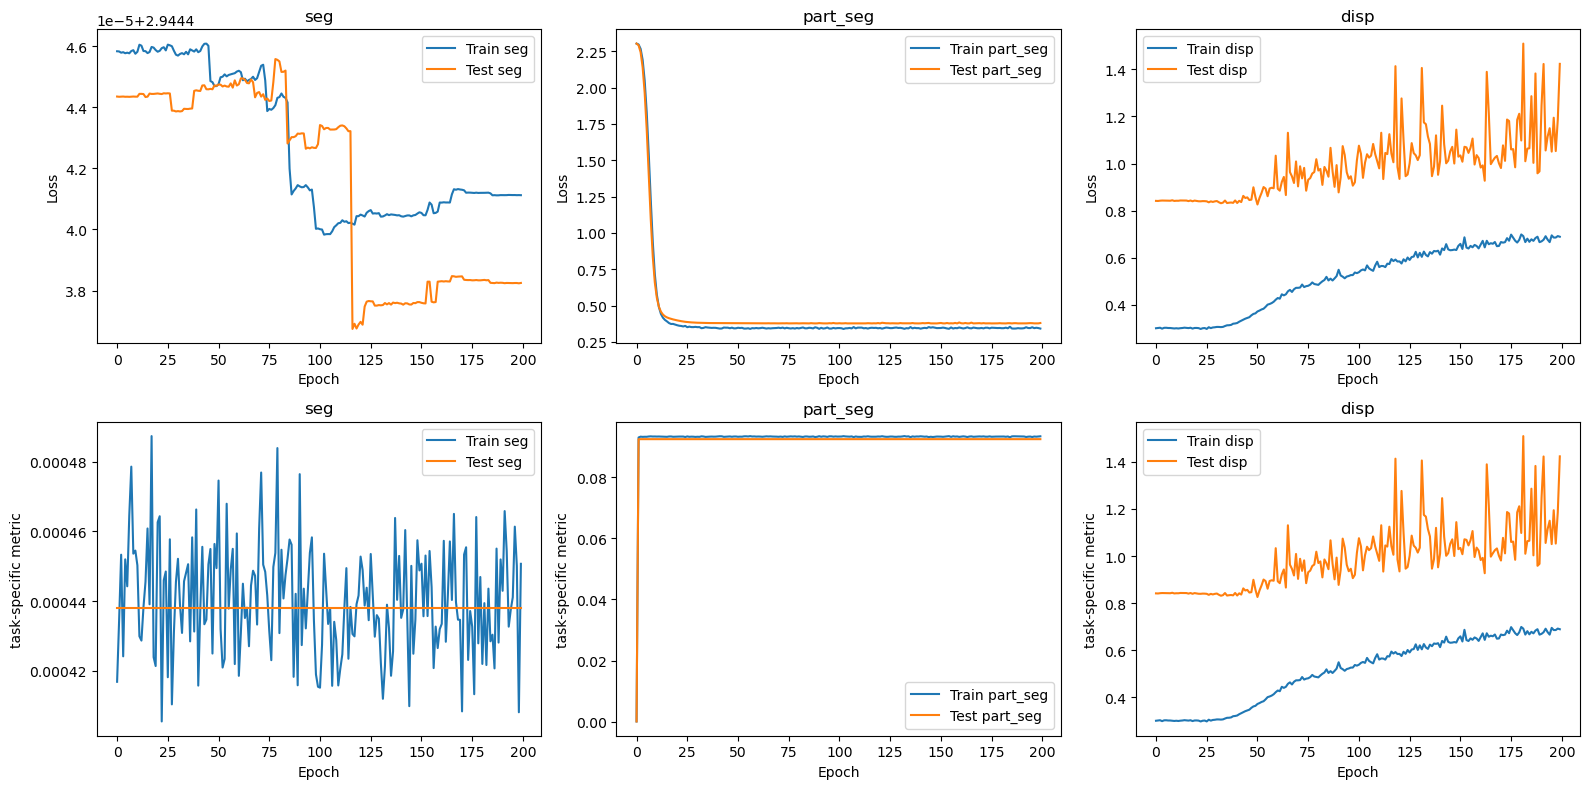


Probando combinación de pesos:  [0.0, 0.6699981061291816, 0.33000189387081835]
Epoch:  0
Época 0000 | TRAIN: Seg 2.9444 0.0005 Part_seg 0.3457 0.0933 Disp 0.5776 0.5776 || TEST: Seg 2.9444 0.0004 Part_seg 0.3780 0.0925 Disp 0.9122 0.9122 | All -0.6366 | Best: All -0.6366
Task Weighting | Seg 0.0000 Part_Seg 0.6700 Disp 0.3300 
Epoch:  1
Época 0001 | TRAIN: Seg 2.9444 0.0004 Part_seg 0.3431 0.0934 Disp 0.5459 0.5459 || TEST: Seg 2.9444 0.0004 Part_seg 0.3816 0.0925 Disp 0.9076 0.9076 | All -0.6348 | Best: All -0.6348
Task Weighting | Seg 0.0000 Part_Seg 0.6700 Disp 0.3300 
Epoch:  2
Época 0002 | TRAIN: Seg 2.9444 0.0004 Part_seg 0.3438 0.0934 Disp 0.5475 0.5475 || TEST: Seg 2.9444 0.0004 Part_seg 0.3781 0.0925 Disp 0.9277 0.9277 | All -0.6428 | Best: All -0.6348
Task Weighting | Seg 0.0000 Part_Seg 0.6700 Disp 0.3300 
Epoch:  3
Época 0003 | TRAIN: Seg 2.9444 0.0004 Part_seg 0.3496 0.0932 Disp 0.5562 0.5562 || TEST: Seg 2.9444 0.0004 Part_seg 0.3824 0.0925 Disp 0.8638 0.8638 | All -0.61

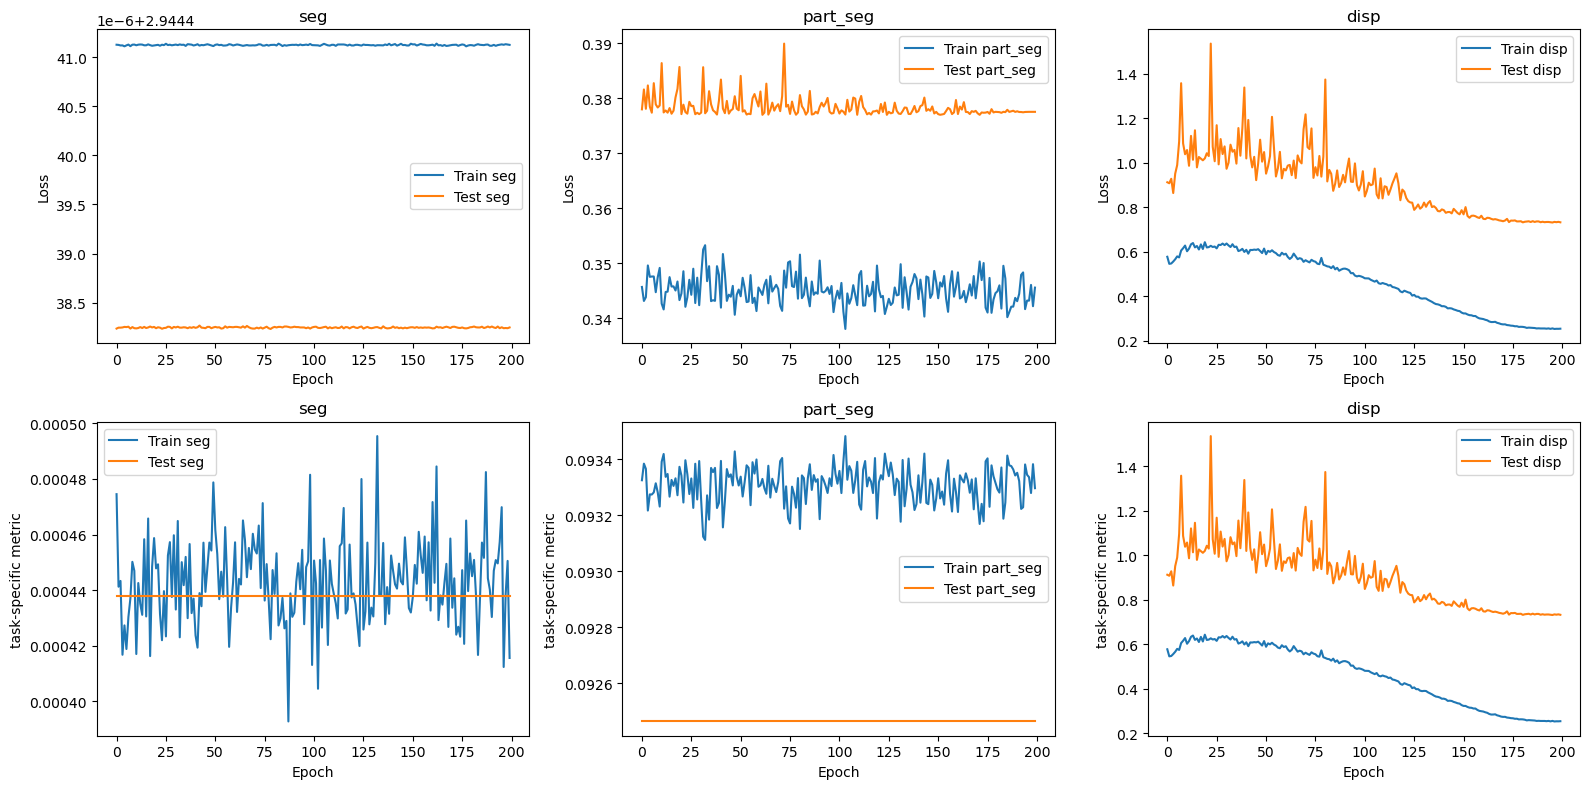


Probando combinación de pesos:  [0.0, 1.0, 0.0]
Epoch:  0
Época 0000 | TRAIN: Seg 2.9444 0.0005 Part_seg 0.3496 0.0932 Disp 0.2554 0.2554 || TEST: Seg 2.9444 0.0004 Part_seg 0.3775 0.0925 Disp 0.7353 0.7353 | All -0.5664 | Best: All -0.5664
Task Weighting | Seg 0.0000 Part_Seg 1.0000 Disp 0.0000 
Epoch:  1
Época 0001 | TRAIN: Seg 2.9444 0.0004 Part_seg 0.3454 0.0933 Disp 0.2555 0.2555 || TEST: Seg 2.9444 0.0004 Part_seg 0.3775 0.0925 Disp 0.7323 0.7323 | All -0.5652 | Best: All -0.5652
Task Weighting | Seg 0.0000 Part_Seg 1.0000 Disp 0.0000 
Epoch:  2
Época 0002 | TRAIN: Seg 2.9444 0.0004 Part_seg 0.3488 0.0932 Disp 0.2549 0.2549 || TEST: Seg 2.9444 0.0004 Part_seg 0.3775 0.0925 Disp 0.7339 0.7339 | All -0.5659 | Best: All -0.5652
Task Weighting | Seg 0.0000 Part_Seg 1.0000 Disp 0.0000 
Epoch:  3
Época 0003 | TRAIN: Seg 2.9444 0.0004 Part_seg 0.3438 0.0933 Disp 0.2552 0.2552 || TEST: Seg 2.9444 0.0004 Part_seg 0.3775 0.0925 Disp 0.7344 0.7344 | All -0.5660 | Best: All -0.5652
Task Wei

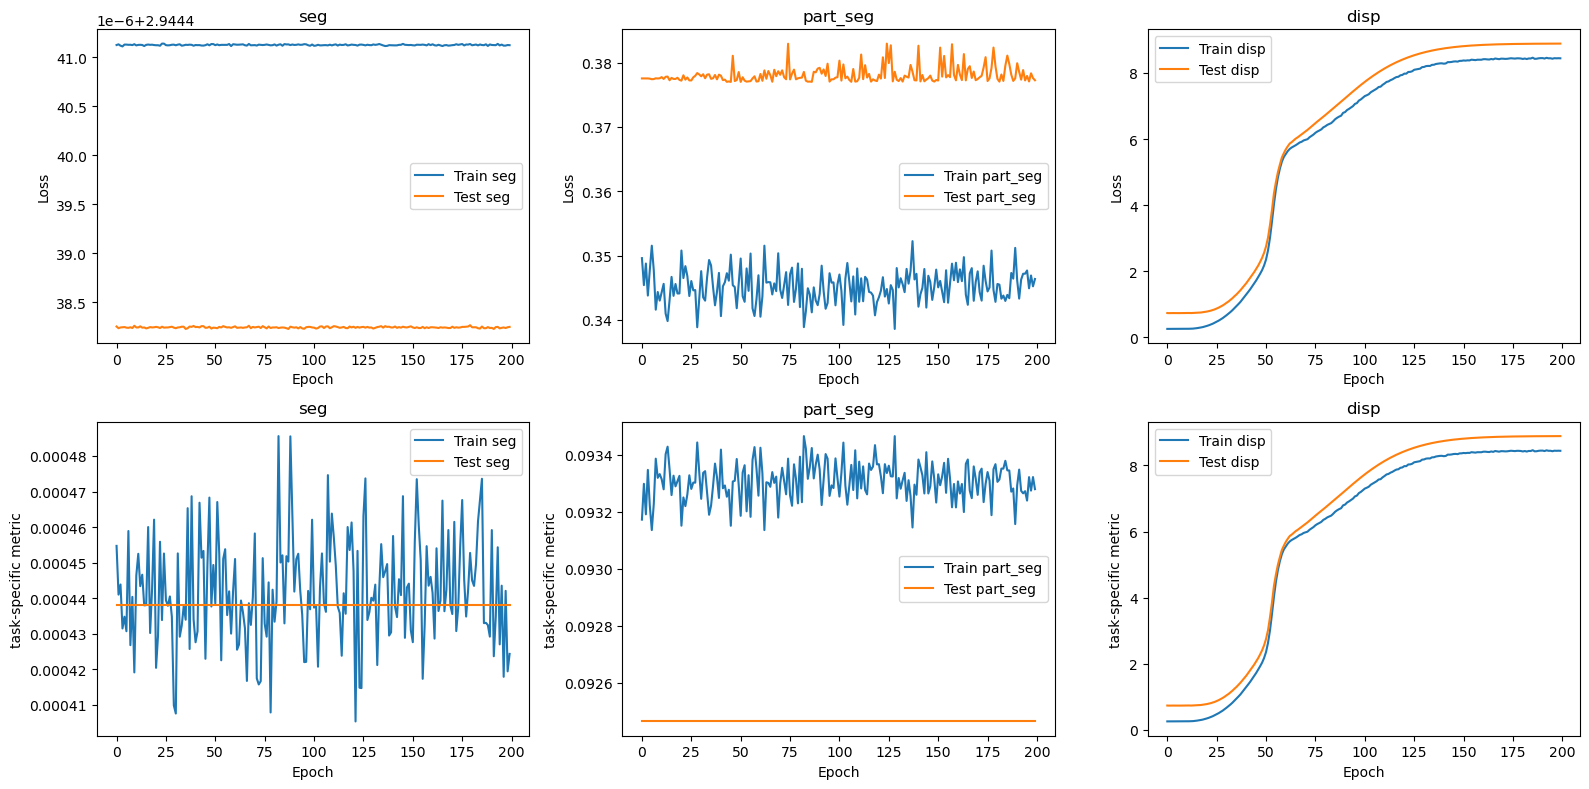


Probando combinación de pesos:  [0.26540554837557906, 0.0, 0.7345944516244209]
Epoch:  0
Época 0000 | TRAIN: Seg 1.8433 0.0214 Part_seg 0.3554 0.0932 Disp 5.8661 5.8661 || TEST: Seg 1.8542 0.0198 Part_seg 0.3876 0.0925 Disp 5.9087 5.9087 | All -2.6079 | Best: All -2.6079
Task Weighting | Seg 0.2654 Part_Seg 0.0000 Disp 0.7346 
Epoch:  1
Época 0001 | TRAIN: Seg 1.7824 0.0215 Part_seg 0.3678 0.0933 Disp 5.8190 5.8190 || TEST: Seg 1.8534 0.0198 Part_seg 0.4063 0.0925 Disp 5.9222 5.9222 | All -2.6132 | Best: All -2.6079
Task Weighting | Seg 0.2654 Part_Seg 0.0000 Disp 0.7346 
Epoch:  2
Época 0002 | TRAIN: Seg 1.7756 0.0215 Part_seg 0.3938 0.0933 Disp 5.8199 5.8199 || TEST: Seg 1.8515 0.0198 Part_seg 0.4348 0.0925 Disp 5.9115 5.9115 | All -2.6090 | Best: All -2.6079
Task Weighting | Seg 0.2654 Part_Seg 0.0000 Disp 0.7346 
Epoch:  3
Época 0003 | TRAIN: Seg 1.7764 0.0216 Part_seg 0.4304 0.0933 Disp 5.8274 5.8274 || TEST: Seg 1.8511 0.0198 Part_seg 0.4731 0.0925 Disp 5.9060 5.9060 | All -2.60

In [3]:
t.train()

Dataset: Cityscapes | Training Task: Seg + Part_Seg + Disp | Primary Task: Seg + Part_Seg + Disp in Multi-task / Auxiliary Learning Mode with SPLIT
Applying Multi-task Methods: Weighting-based: Combinations + Gradient-based: NONE
primer lambda  (200, 3)

Probando combinación de pesos:  [0.29410141198323037, 0.408241369762401, 0.29765721825436864]
Epoch:  0
Época 0000 | TRAIN: Seg 0.8432 0.1562 Part_seg 0.2176 0.1336 Disp 1.6031 1.6031 || TEST: Seg 0.8113 0.1796 Part_seg 0.1996 0.1552 Disp 1.5895 1.5895 | All -0.7595 | Best: All -0.7595
Task Weighting | Seg 0.2941 Part_Seg 0.4082 Disp 0.2977 
Epoch:  1
Época 0001 | TRAIN: Seg 0.6372 0.2080 Part_seg 0.1616 0.1768 Disp 1.2239 1.2239 || TEST: Seg 0.7716 0.1948 Part_seg 0.1820 0.1941 Disp 1.4096 1.4096 | All -0.6545 | Best: All -0.6545
Task Weighting | Seg 0.2941 Part_Seg 0.4082 Disp 0.2977 
Epoch:  2
Época 0002 | TRAIN: Seg 0.5483 0.2406 Part_seg 0.1422 0.2060 Disp 1.0838 1.0838 || TEST: Seg 0.7695 0.2086 Part_seg 0.2285 0.1489 Disp 1.3792

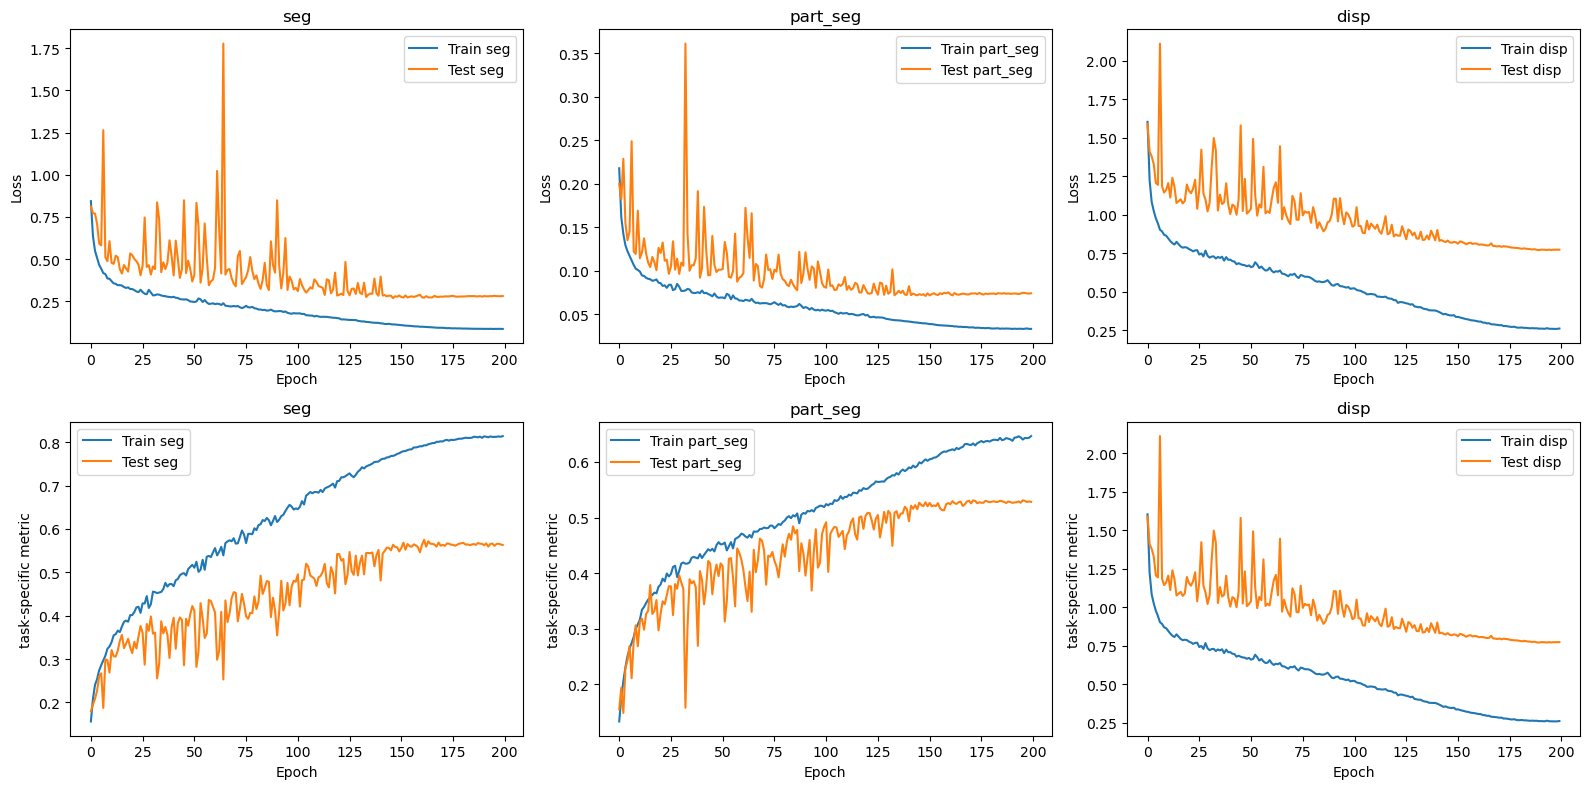


Probando combinación de pesos:  [0.33409163145841364, 0.6659083685415864, 0.0]
Epoch:  0
Época 0000 | TRAIN: Seg 0.0857 0.8120 Part_seg 0.0333 0.6442 Disp 0.2607 0.2607 || TEST: Seg 0.2782 0.5628 Part_seg 0.0741 0.5260 Disp 0.7723 0.7723 | All 0.0264 | Best: All 0.0264
Task Weighting | Seg 0.3341 Part_Seg 0.6659 Disp 0.0000 
Epoch:  1
Época 0001 | TRAIN: Seg 0.0852 0.8150 Part_seg 0.0330 0.6455 Disp 0.2620 0.2620 || TEST: Seg 0.2788 0.5672 Part_seg 0.0737 0.5283 Disp 0.7722 0.7722 | All 0.0306 | Best: All 0.0306
Task Weighting | Seg 0.3341 Part_Seg 0.6659 Disp 0.0000 
Epoch:  2
Época 0002 | TRAIN: Seg 0.0856 0.8138 Part_seg 0.0332 0.6444 Disp 0.2623 0.2623 || TEST: Seg 0.2786 0.5646 Part_seg 0.0739 0.5287 Disp 0.7734 0.7734 | All 0.0287 | Best: All 0.0306
Task Weighting | Seg 0.3341 Part_Seg 0.6659 Disp 0.0000 
Epoch:  3
Época 0003 | TRAIN: Seg 0.0853 0.8131 Part_seg 0.0333 0.6452 Disp 0.2600 0.2600 || TEST: Seg 0.2796 0.5645 Part_seg 0.0742 0.5283 Disp 0.7737 0.7737 | All 0.0283 | Be

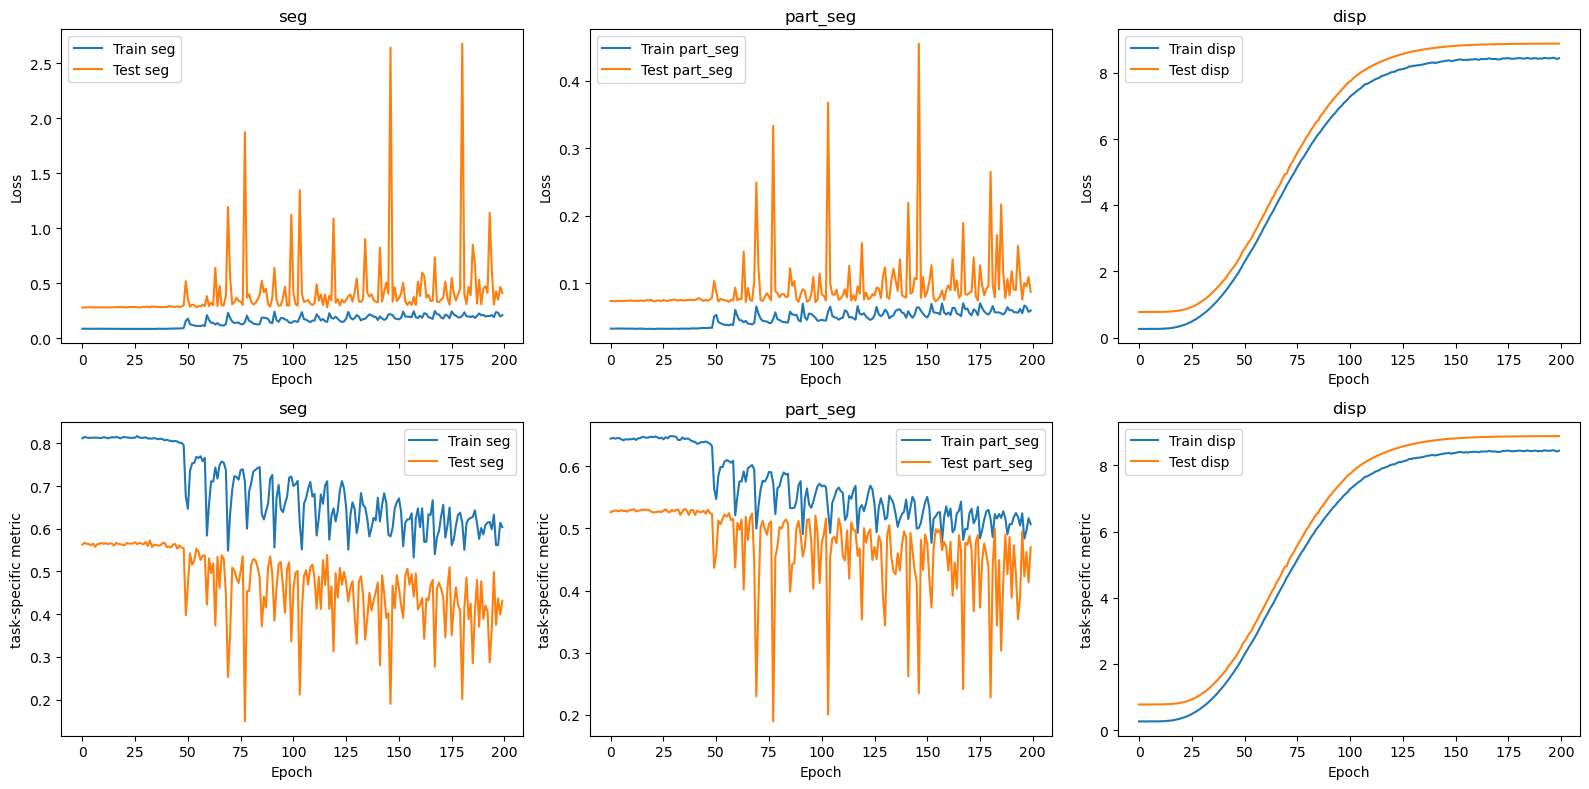


Probando combinación de pesos:  [0.44821967389907136, 0.10150983781364359, 0.45027048828728505]
Epoch:  0
Época 0000 | TRAIN: Seg 0.2238 0.5881 Part_seg 0.0552 0.5235 Disp 5.8708 5.8708 || TEST: Seg 0.7389 0.3192 Part_seg 0.1337 0.3551 Disp 5.9154 5.9154 | All -2.2670 | Best: All -2.2670
Task Weighting | Seg 0.4482 Part_Seg 0.1015 Disp 0.4503 
Epoch:  1
Época 0001 | TRAIN: Seg 0.2324 0.5685 Part_seg 0.0576 0.5120 Disp 5.8251 5.8251 || TEST: Seg 0.3868 0.4354 Part_seg 0.0850 0.4589 Disp 5.9175 5.9175 | All -2.1332 | Best: All -2.1332
Task Weighting | Seg 0.4482 Part_Seg 0.1015 Disp 0.4503 
Epoch:  2
Época 0002 | TRAIN: Seg 0.2082 0.5935 Part_seg 0.0554 0.5227 Disp 5.8231 5.8231 || TEST: Seg 0.3328 0.4807 Part_seg 0.0776 0.4898 Disp 5.9136 5.9136 | All -2.0853 | Best: All -2.0853
Task Weighting | Seg 0.4482 Part_Seg 0.1015 Disp 0.4503 
Epoch:  3
Época 0003 | TRAIN: Seg 0.1957 0.6308 Part_seg 0.0546 0.5296 Disp 5.8282 5.8282 || TEST: Seg 0.3256 0.4953 Part_seg 0.0775 0.4961 Disp 5.9203 5

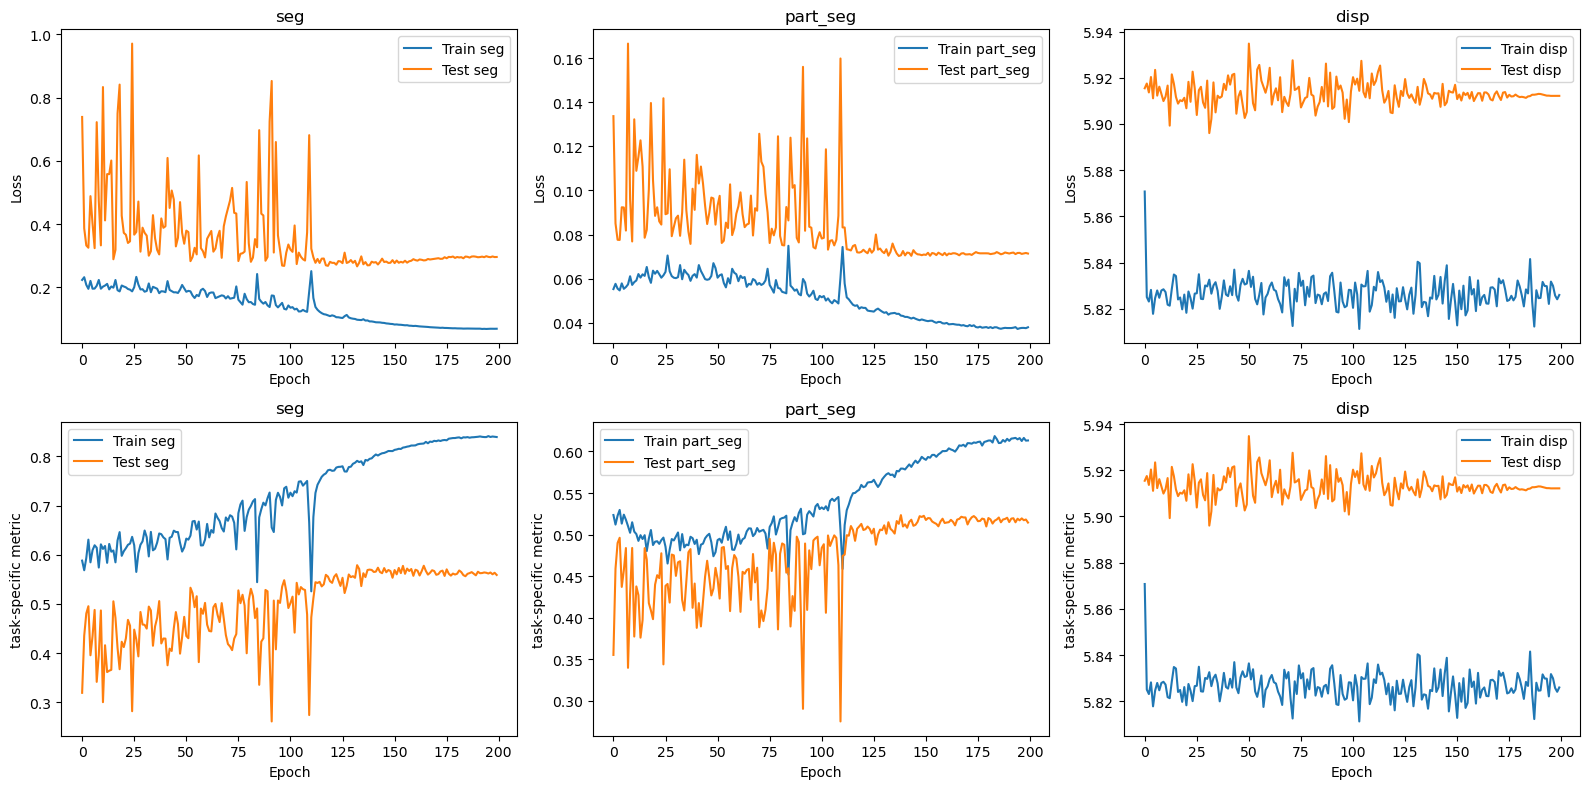


Probando combinación de pesos:  [0.6607211994652964, 0.33927880053470355, 0.0]
Epoch:  0
Época 0000 | TRAIN: Seg 0.0696 0.8395 Part_seg 0.0378 0.6168 Disp 5.8325 5.8325 || TEST: Seg 0.2991 0.5613 Part_seg 0.0717 0.5165 Disp 5.9122 5.9122 | All -2.0201 | Best: All -2.0201
Task Weighting | Seg 0.6607 Part_Seg 0.3393 Disp 0.0000 
Epoch:  1
Época 0001 | TRAIN: Seg 0.0691 0.8405 Part_seg 0.0375 0.6192 Disp 5.8259 5.8259 || TEST: Seg 0.2971 0.5608 Part_seg 0.0714 0.5192 Disp 5.9122 5.9122 | All -2.0186 | Best: All -2.0186
Task Weighting | Seg 0.6607 Part_Seg 0.3393 Disp 0.0000 
Epoch:  2
Época 0002 | TRAIN: Seg 0.0688 0.8425 Part_seg 0.0378 0.6158 Disp 5.8195 5.8195 || TEST: Seg 0.2954 0.5613 Part_seg 0.0714 0.5144 Disp 5.9122 5.9122 | All -2.0214 | Best: All -2.0186
Task Weighting | Seg 0.6607 Part_Seg 0.3393 Disp 0.0000 
Epoch:  3
Época 0003 | TRAIN: Seg 0.0691 0.8391 Part_seg 0.0376 0.6142 Disp 5.8286 5.8286 || TEST: Seg 0.2994 0.5643 Part_seg 0.0716 0.5178 Disp 5.9122 5.9122 | All -2.01

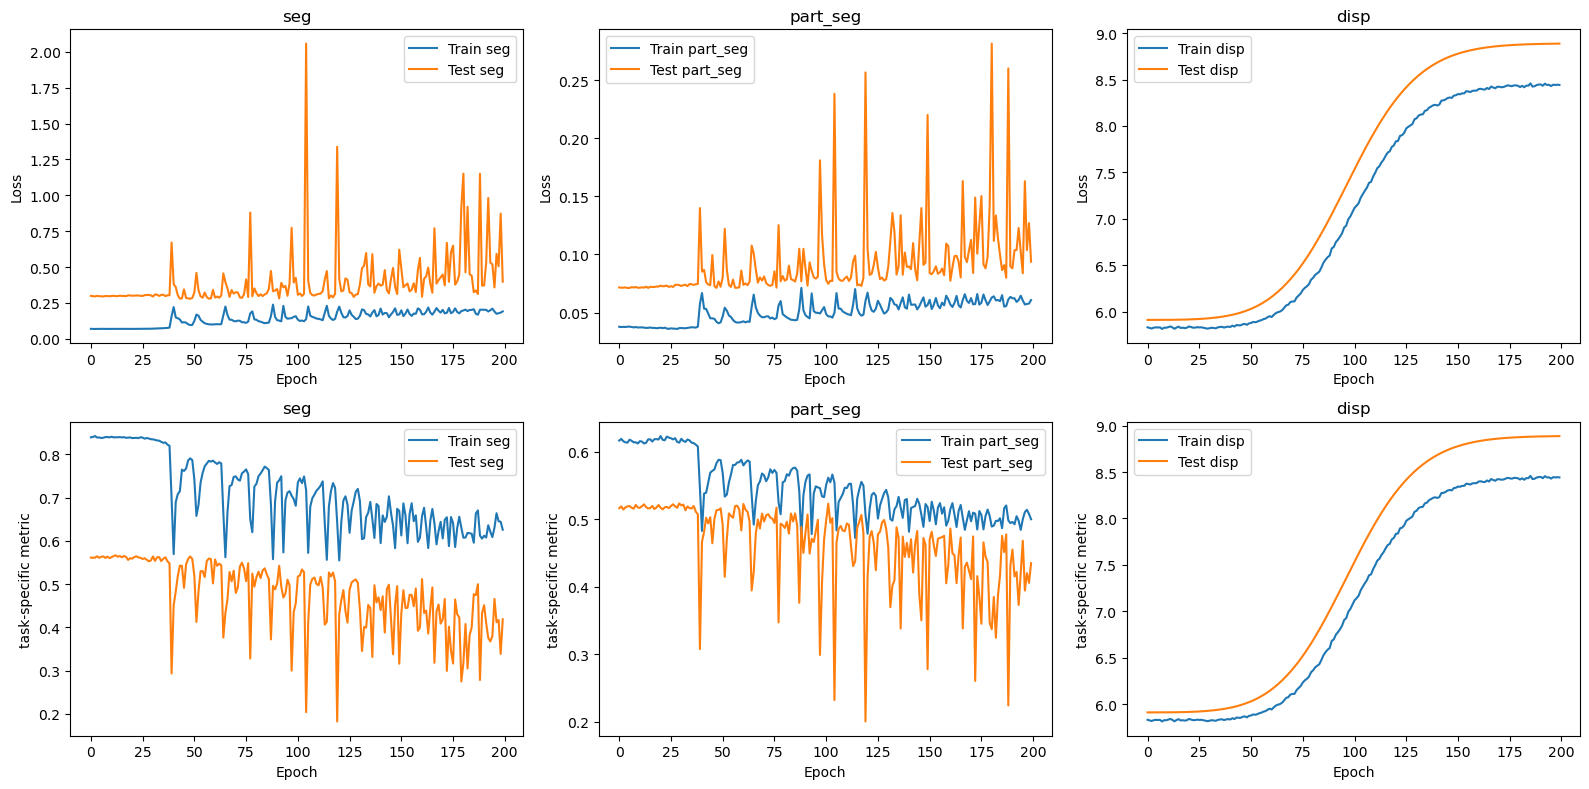


Probando combinación de pesos:  [0.7328688454666205, 0.0, 0.2671311545333795]
Epoch:  0
Época 0000 | TRAIN: Seg 0.2419 0.5438 Part_seg 0.0713 0.4560 Disp 5.8896 5.8896 || TEST: Seg 0.4319 0.4135 Part_seg 0.0971 0.4035 Disp 5.9114 5.9114 | All -2.1789 | Best: All -2.1789
Task Weighting | Seg 0.7329 Part_Seg 0.0000 Disp 0.2671 
Epoch:  1
Época 0001 | TRAIN: Seg 0.2181 0.5758 Part_seg 0.0735 0.4498 Disp 5.8181 5.8181 || TEST: Seg 0.4912 0.3658 Part_seg 0.1129 0.3906 Disp 5.9209 5.9209 | All -2.2190 | Best: All -2.1789
Task Weighting | Seg 0.7329 Part_Seg 0.0000 Disp 0.2671 
Epoch:  2
Época 0002 | TRAIN: Seg 0.1853 0.6460 Part_seg 0.0793 0.4676 Disp 5.8190 5.8190 || TEST: Seg 0.4764 0.4059 Part_seg 0.1250 0.3775 Disp 5.9161 5.9161 | All -2.2017 | Best: All -2.1789
Task Weighting | Seg 0.7329 Part_Seg 0.0000 Disp 0.2671 
Epoch:  3
Época 0003 | TRAIN: Seg 0.2010 0.6172 Part_seg 0.0997 0.4521 Disp 5.8269 5.8269 || TEST: Seg 0.5564 0.4096 Part_seg 0.1388 0.3893 Disp 5.9068 5.9068 | All -2.188

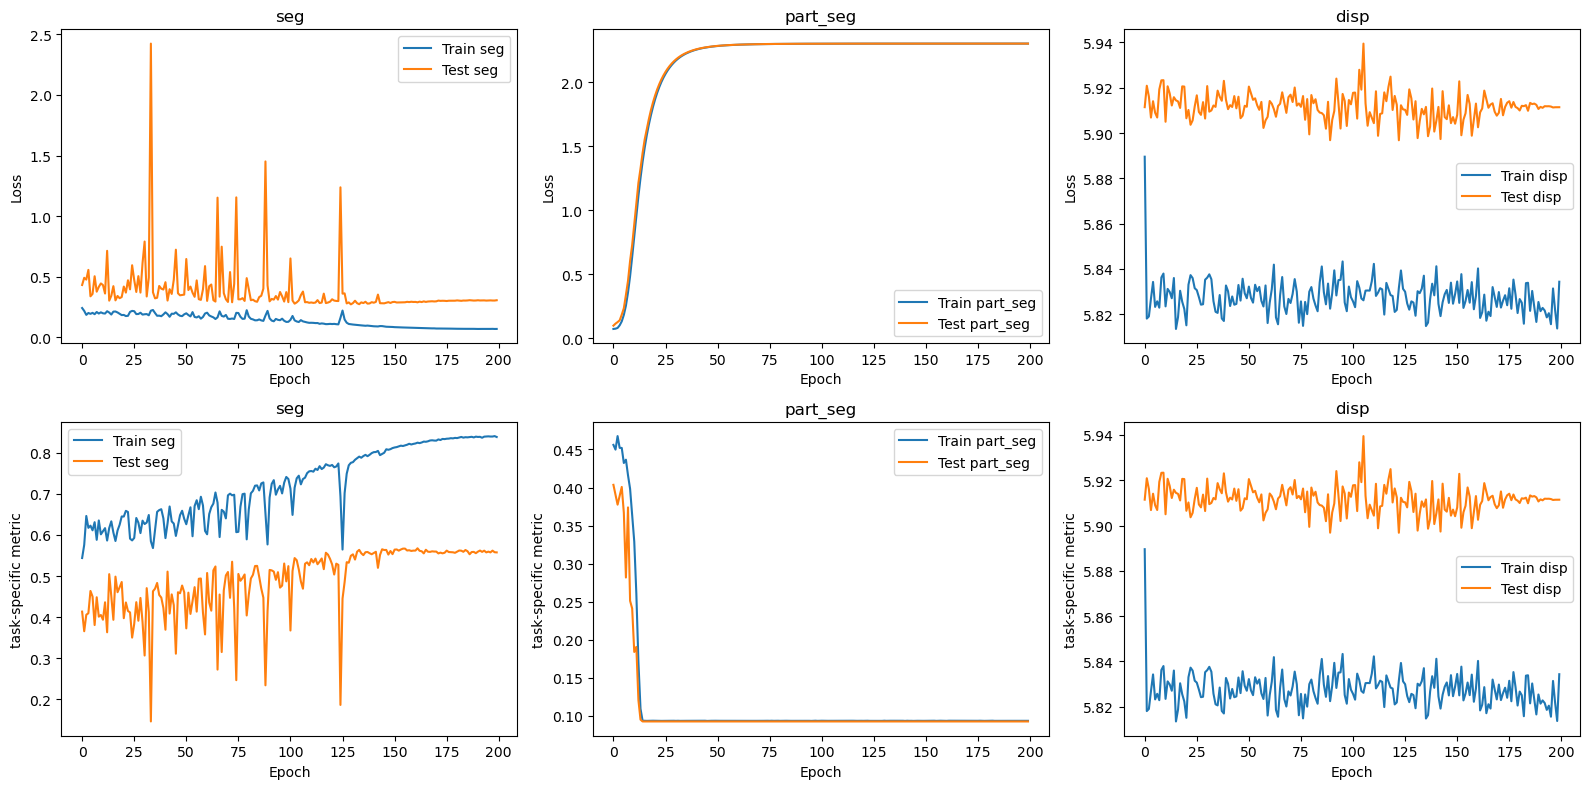


Probando combinación de pesos:  [1.0, 0.0, 0.0]
Epoch:  0
Época 0000 | TRAIN: Seg 0.0693 0.8381 Part_seg 2.3023 0.0933 Disp 5.8266 5.8266 || TEST: Seg 0.3060 0.5569 Part_seg 2.3023 0.0925 Disp 5.9114 5.9114 | All -2.2904 | Best: All -2.2904
Task Weighting | Seg 1.0000 Part_Seg 0.0000 Disp 0.0000 
Epoch:  1
Época 0001 | TRAIN: Seg 0.0693 0.8395 Part_seg 2.3023 0.0933 Disp 5.8325 5.8325 || TEST: Seg 0.3040 0.5610 Part_seg 2.3023 0.0925 Disp 5.9114 5.9114 | All -2.2880 | Best: All -2.2880
Task Weighting | Seg 1.0000 Part_Seg 0.0000 Disp 0.0000 
Epoch:  2
Época 0002 | TRAIN: Seg 0.0694 0.8391 Part_seg 2.3023 0.0933 Disp 5.8383 5.8383 || TEST: Seg 0.3053 0.5593 Part_seg 2.3023 0.0925 Disp 5.9114 5.9114 | All -2.2890 | Best: All -2.2880
Task Weighting | Seg 1.0000 Part_Seg 0.0000 Disp 0.0000 
Epoch:  3
Época 0003 | TRAIN: Seg 0.0692 0.8386 Part_seg 2.3023 0.0933 Disp 5.8290 5.8290 || TEST: Seg 0.3056 0.5594 Part_seg 2.3023 0.0925 Disp 5.9115 5.9115 | All -2.2889 | Best: All -2.2880
Task Wei

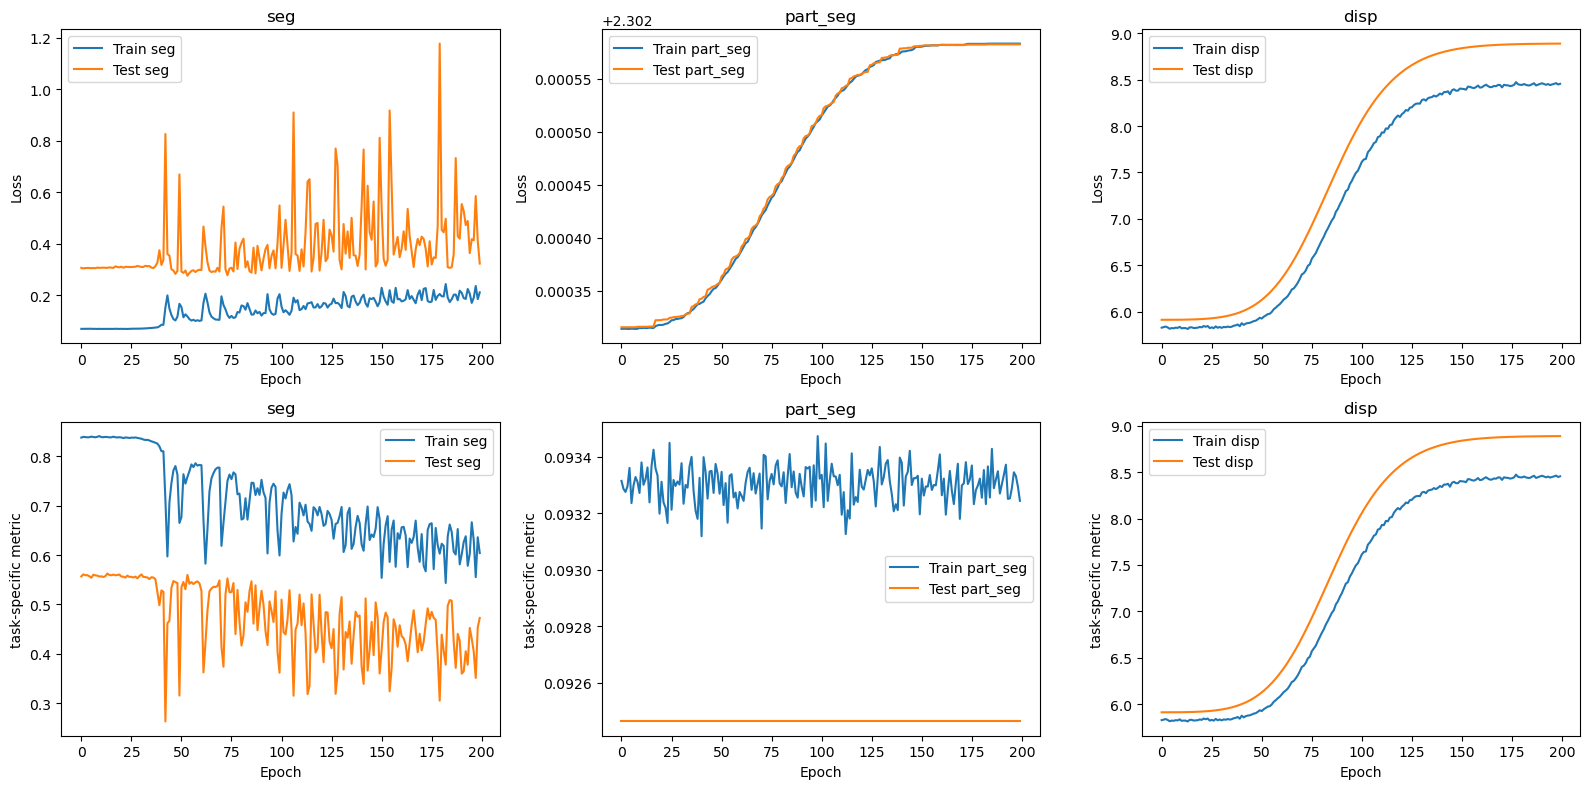

In [2]:
t = trainerDense(dataset = 'cityscapes', total_epoch = 200, weight = 'combinations')
t.initialize()
t.choose_task_weighting(weight = 'combinations')
t.define_dataset(dataset = 'cityscapes')
t.train()